In [405]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns
from scipy.integrate import simpson

In [327]:
def read_coords(file):
    lines = []
    while not (line := file.readline()).startswith("% Data"):
        lines.append(line.strip())
    return lines


def read_data(file):
    lines = []
    while not (line := file.readline()).startswith("% Data"):
        if not line:
            break
        lines.append(line.strip())
    return lines


def process_header(line):
    name, freq = line.strip("% |\n").split(" @ ")
    name, unit = name.replace("emw.", "").split(" ")
    unit = unit.strip("()")
    freq = float(freq.strip("freq="))
    return name, unit, freq

In [298]:
root = Path(
    "/Users/monochromatti/University/driven_nickelate/src/driven_nickelate/simulations/data/29.02.24/cond_6e3"
)
paths = [f for f in root.glob("*.csv") if "spatial_data" in f.name]

lazyframes = []
for path in paths:
    with open(path) as f:
        while not f.readline().startswith("% Grid"):
            continue

        x_str, y_str = read_coords(f)
        y = pl.Series("y", y_str.split(",")).cast(pl.Float64)

        while line := f.readline():
            name, unit, freq = process_header(line)
            data = read_data(f)
            data = [s.strip().split(",") for s in data]
            data = (
                pl.LazyFrame(data, schema=x_str.split(","))
                .with_columns(y)
                .unpivot(
                    index="y",
                    variable_name="x",
                )
                .select(
                    pl.lit(name).alias("variable"),
                    pl.lit(unit).alias("unit"),
                    pl.lit(freq).alias("freq"),
                    pl.col("x").cast(pl.Float64),
                    pl.col("y"),
                    pl.col("value").cast(pl.Float64),
                )
            )
            lazyframes.append(data)

data = pl.concat(lazyframes).sort("freq").collect()

<Axes: xlabel='x', ylabel='y'>

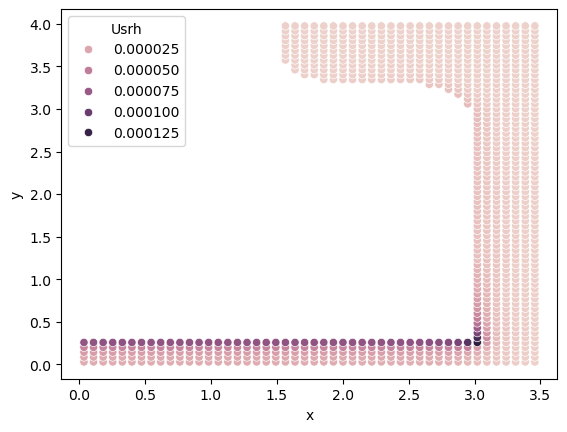

In [355]:
loss_data = (
    data.filter(pl.col("variable").is_in(["Qsrh", "real(sigmabnd)"]))
    .pivot(index=["x", "y", "freq"], columns=["variable"], values="value")
    .with_columns((pl.col("Qsrh") * 600e-9 * 6e-6).alias("Usrh"))
)

freq_filter = (pl.col("freq") - 1.0).abs() < 0.01
space_filter = (pl.col("x") < 3.5) & (pl.col("y") < 4.0)
sns.scatterplot(loss_data.filter(freq_filter & space_filter), x="x", y="y", hue="Usrh")

In [356]:
freq_data = (
    loss_data.filter((pl.col("x") < 3.0) & (pl.col("y") < 0.1))
    .group_by("freq")
    .mean()
    .sort("freq")
)

freq, Usrh = freq_data.select("freq", "Usrh").get_columns()

integral = simpson(y=Usrh, x=freq)
print(integral)

2.2721413735314385e-05


In [399]:
gap_filter = (pl.col("x") < 3.0) & (pl.col("y") < 0.3)
gap_data = (
    data.filter(
        gap_filter
        & pl.col("variable").is_in(
            ["real(Jsupy)", "imag(Jsupy)", "real(Ey)", "imag(Ey)"]
        )
    )
    .pivot(index=["x", "y", "freq"], columns=["variable"], values="value")
    .group_by("freq")
    .mean()
    .drop("x", "y")
    .sort("freq")
)

554671.0955070996

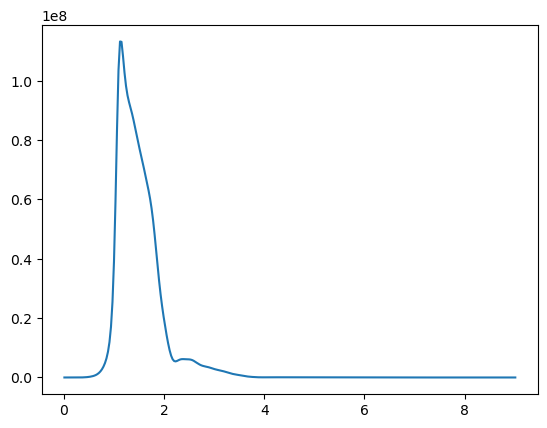

In [468]:
Er, Ei = gap_data.select("real(Ey)", "imag(Ey)").get_columns()
E = Er.to_numpy() + 1j * Ei.to_numpy()

Jr, Ji = gap_data.select("real(Jsupy)", "imag(Jsupy)").get_columns()
J = Jr.to_numpy() + 1j * Ji.to_numpy()

freq = gap_data.get_column("freq").to_numpy()
Q = 0.5 * E * J

fig, ax = plt.subplots()

ax.plot(freq, np.abs(Q))

np.abs(simpson(y=Q, x=freq))

-725446.2103354661


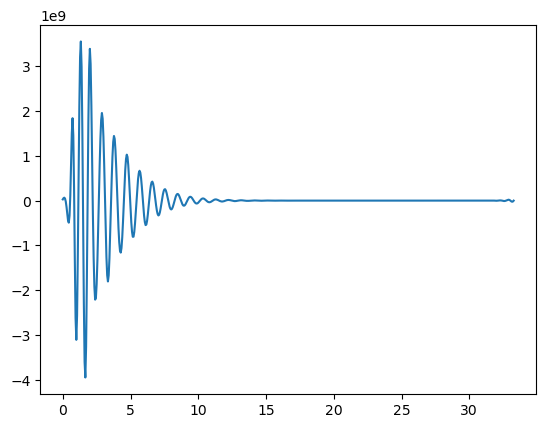

In [466]:
M = (len(freq) - 1) * 2
time = np.arange(M) / (M * (freq[1] - freq[0]))

Qt = np.fft.irfft(Q, norm="forward")

fig, ax = plt.subplots(1, 1)
ax.plot(time, Qt)

U = simpson(y=Qt, x=time)
print(U)